# TrendKart Sales Forecasting - Time Series Analysis

## Problem Statement
TrendKart wants to forecast monthly sales for the upcoming year to improve inventory planning, optimize supply chain operations, and prevent overstocking or stockouts.

## Objective
To build a time series model that:
- Identifies trends and seasonal patterns
- Assists in making data-driven business decisions

## Dataset Information
The dataset includes:
- **Month**: Monthly timestamp from Jan 2019 to Dec 2023
- **Total_Sales**: Simulated total sales with trend, seasonality, and noise
- **Promotions**: Binary indicator for promotional campaigns
- **Festive_Season**: Binary flag for festive months (Oct–Dec)
- **Online_Sales_Ratio**: Proportion of sales from online channels (20% to 50%)

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Time series specific imports
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Set plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


## 1. Data Preprocessing

In [2]:
# Load the dataset
df = pd.read_csv('trend.csv')

print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nBasic statistics:")
print(df.describe())

Dataset shape: (60, 5)

First 5 rows:
        Month  Total_Sales  Promotions  Festive_Season  Online_Sales_Ratio
0  2019-01-01     20745.07           0               0                0.25
1  2019-02-01     21442.60           0               0                0.35
2  2019-03-01     23869.61           0               0                0.35
3  2019-04-01     25734.54           0               0                0.47
4  2019-05-01     22846.85           1               0                0.34

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Month               60 non-null     object 
 1   Total_Sales         60 non-null     float64
 2   Promotions          60 non-null     int64  
 3   Festive_Season      60 non-null     int64  
 4   Online_Sales_Ratio  60 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage

In [3]:
# Convert Month column to datetime type
df['Month'] = pd.to_datetime(df['Month'])

# Set Month as index
df.set_index('Month', inplace=True)

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Handle missing values (filling with forward fill and backward fill as specified not to remove)
if df.isnull().sum().sum() > 0:
    print("\nHandling missing values with forward fill and backward fill...")
    df = df.fillna(method='ffill').fillna(method='bfill')
    print("Missing values after handling:")
    print(df.isnull().sum())
else:
    print("\nNo missing values found in the dataset!")

print("\nProcessed dataset shape:", df.shape)
print("\nDate range:", df.index.min(), "to", df.index.max())
print("\nFinal dataset:")
print(df.head())

Missing values per column:
Total_Sales           0
Promotions            0
Festive_Season        0
Online_Sales_Ratio    0
dtype: int64

No missing values found in the dataset!

Processed dataset shape: (60, 4)

Date range: 2019-01-01 00:00:00 to 2023-12-01 00:00:00

Final dataset:
            Total_Sales  Promotions  Festive_Season  Online_Sales_Ratio
Month                                                                  
2019-01-01     20745.07           0               0                0.25
2019-02-01     21442.60           0               0                0.35
2019-03-01     23869.61           0               0                0.35
2019-04-01     25734.54           0               0                0.47
2019-05-01     22846.85           1               0                0.34


## 2. Exploratory Data Analysis (EDA)

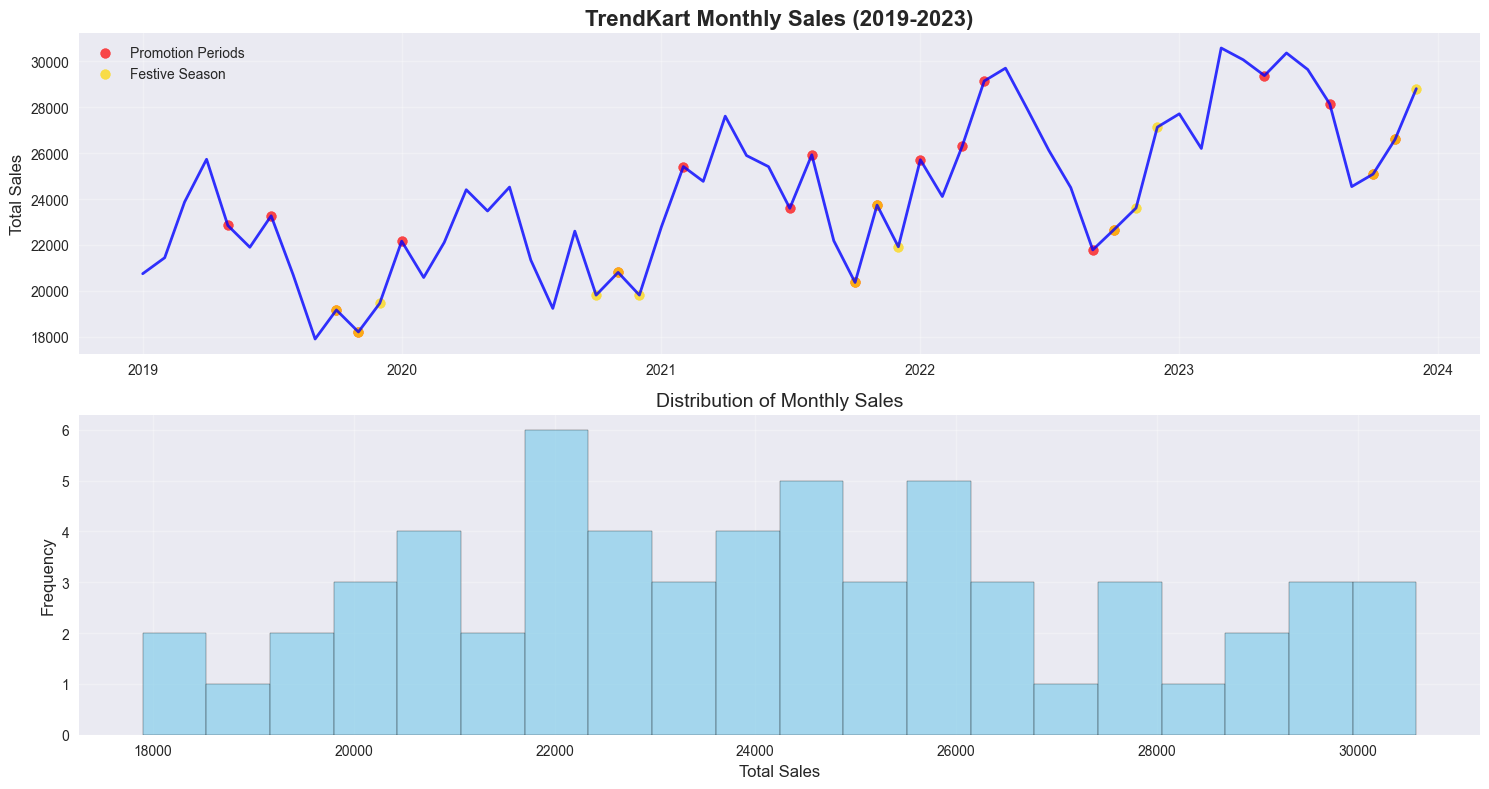

📊 INTERPRETATION:
1. The sales data shows a clear upward trend over the 5-year period
2. There appears to be seasonal variation with some cyclical patterns
3. Sales range approximately from 17,000 to 31,000 with most values clustered around 23,000-26,000
4. Promotional periods (red dots) and festive seasons (yellow dots) are scattered throughout the timeline


In [4]:
# Plot raw sales data to observe trends, seasonality, and cyclical components
plt.figure(figsize=(15, 8))

# Main time series plot
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Total_Sales'], linewidth=2, color='blue', alpha=0.8)
plt.title('TrendKart Monthly Sales (2019-2023)', fontsize=16, fontweight='bold')
plt.ylabel('Total Sales', fontsize=12)
plt.grid(True, alpha=0.3)

# Add markers for promotional periods
promo_periods = df[df['Promotions'] == 1]
plt.scatter(promo_periods.index, promo_periods['Total_Sales'], 
           color='red', alpha=0.7, s=50, label='Promotion Periods')

# Add markers for festive seasons
festive_periods = df[df['Festive_Season'] == 1]
plt.scatter(festive_periods.index, festive_periods['Total_Sales'], 
           color='gold', alpha=0.7, s=50, label='Festive Season')

plt.legend()

# Distribution of sales
plt.subplot(2, 1, 2)
plt.hist(df['Total_Sales'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Monthly Sales', fontsize=14)
plt.xlabel('Total Sales', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 INTERPRETATION:")
print("1. The sales data shows a clear upward trend over the 5-year period")
print("2. There appears to be seasonal variation with some cyclical patterns")
print("3. Sales range approximately from 17,000 to 31,000 with most values clustered around 23,000-26,000")
print("4. Promotional periods (red dots) and festive seasons (yellow dots) are scattered throughout the timeline")

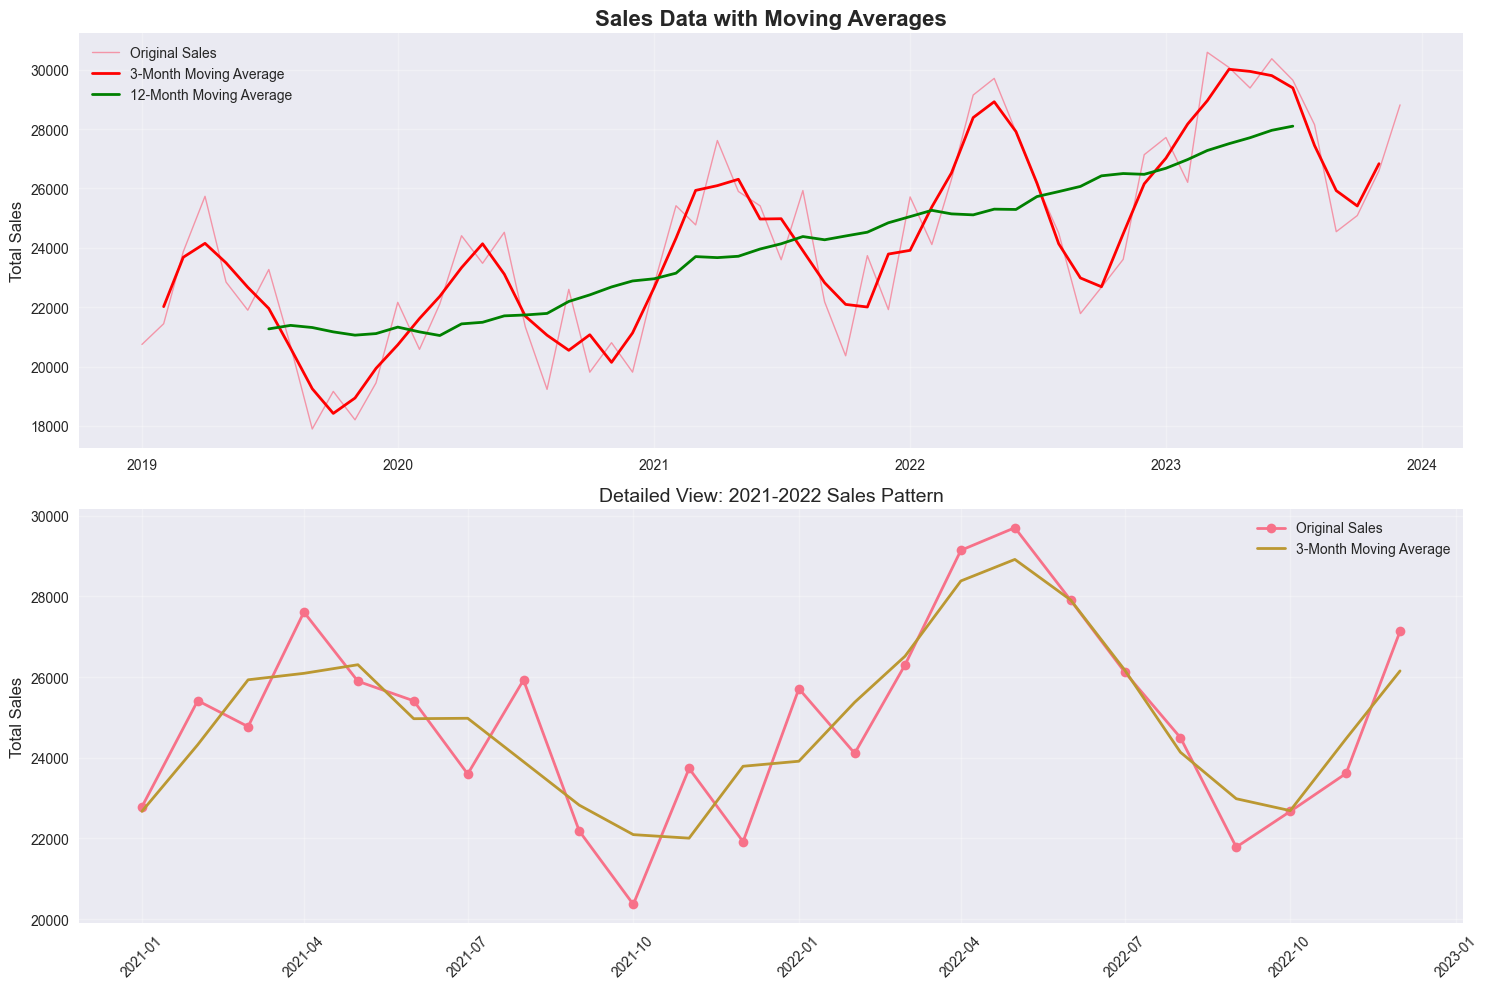

📊 MOVING AVERAGES INTERPRETATION:
1. 3-Month Moving Average: Smooths short-term fluctuations, reveals local trends
2. 12-Month Moving Average: Shows the overall yearly trend, removing seasonal effects
3. The 12-month MA clearly shows the consistent upward trend in sales
4. Seasonal patterns become more visible when comparing original data with smoothed versions


In [5]:
# Calculate moving averages to smooth out noise
df['MA_3'] = df['Total_Sales'].rolling(window=3, center=True).mean()
df['MA_12'] = df['Total_Sales'].rolling(window=12, center=True).mean()

# Plot moving averages
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(df.index, df['Total_Sales'], label='Original Sales', linewidth=1, alpha=0.7)
plt.plot(df.index, df['MA_3'], label='3-Month Moving Average', linewidth=2, color='red')
plt.plot(df.index, df['MA_12'], label='12-Month Moving Average', linewidth=2, color='green')
plt.title('Sales Data with Moving Averages', fontsize=16, fontweight='bold')
plt.ylabel('Total Sales', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Zoom in on a specific period to see seasonal patterns better
plt.subplot(2, 1, 2)
zoom_data = df['2021':'2022']
plt.plot(zoom_data.index, zoom_data['Total_Sales'], label='Original Sales', linewidth=2, marker='o')
plt.plot(zoom_data.index, zoom_data['MA_3'], label='3-Month Moving Average', linewidth=2)
plt.title('Detailed View: 2021-2022 Sales Pattern', fontsize=14)
plt.ylabel('Total Sales', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("📊 MOVING AVERAGES INTERPRETATION:")
print("1. 3-Month Moving Average: Smooths short-term fluctuations, reveals local trends")
print("2. 12-Month Moving Average: Shows the overall yearly trend, removing seasonal effects")
print("3. The 12-month MA clearly shows the consistent upward trend in sales")
print("4. Seasonal patterns become more visible when comparing original data with smoothed versions")

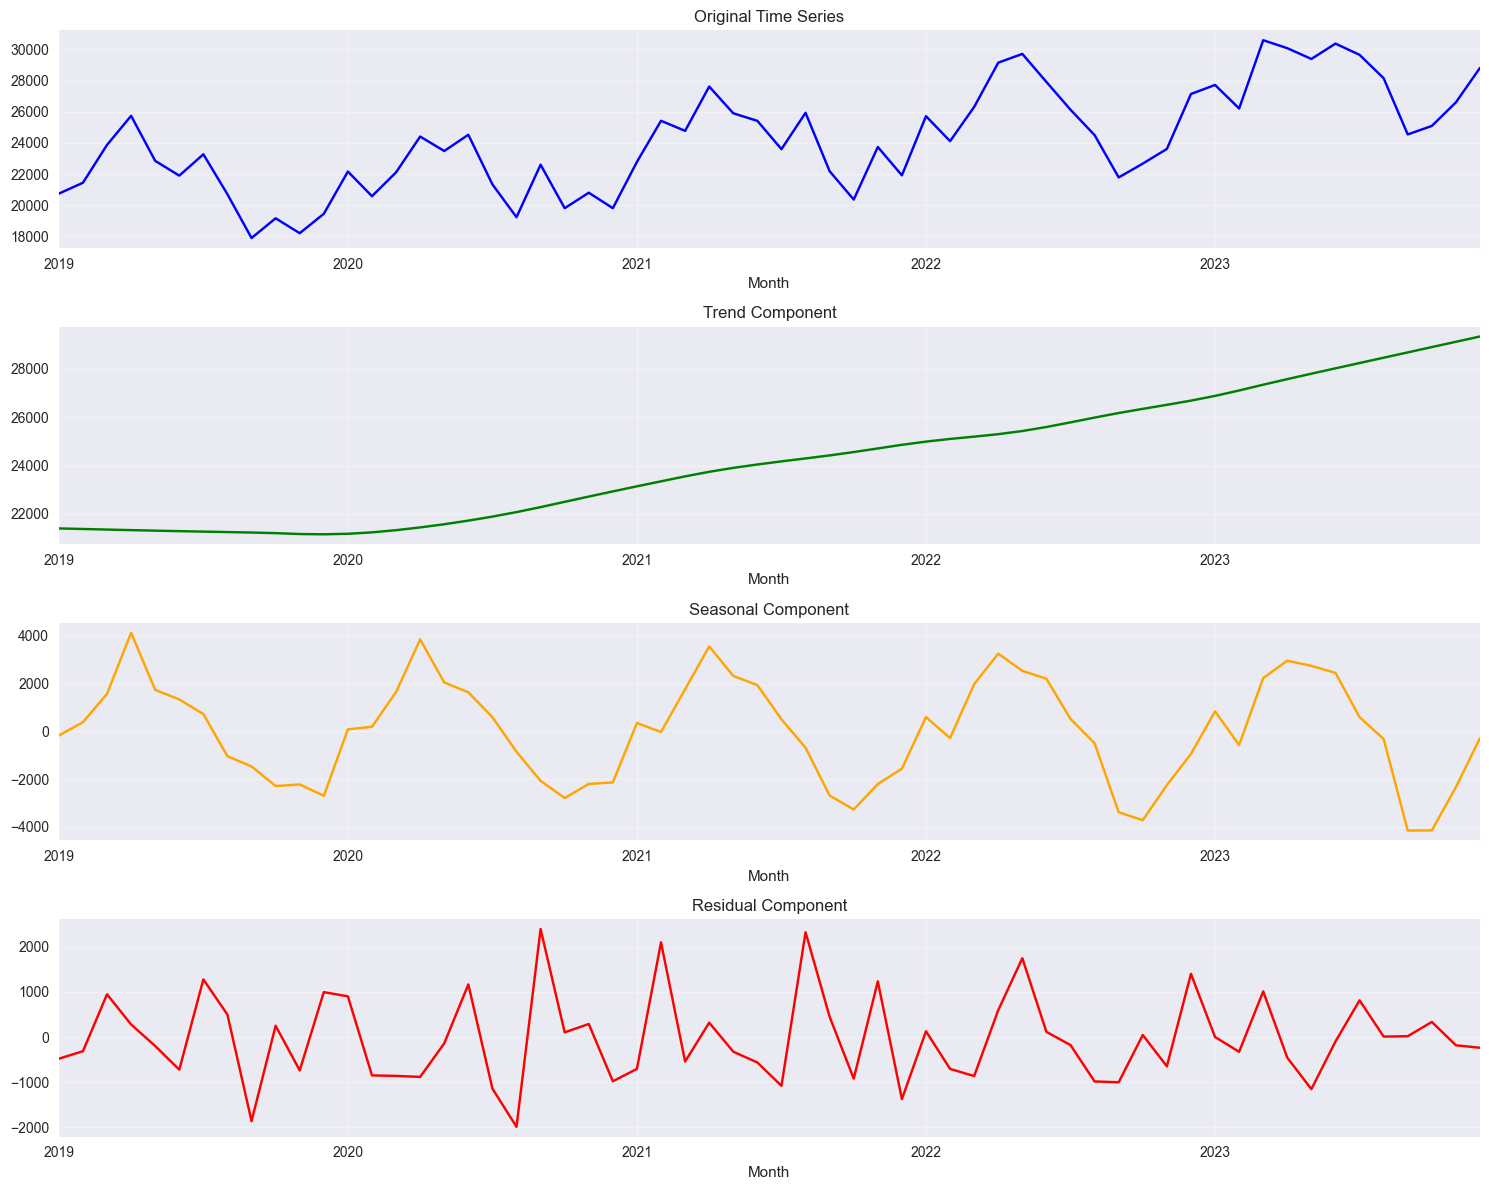

📊 SEASONAL DECOMPOSITION INTERPRETATION:
1. Seasonal Strength: 0.4178
2. Trend Strength: 0.6143
3. TREND: Shows a clear upward trajectory over the 5-year period
4. SEASONALITY: Exhibits regular seasonal patterns with peaks and troughs
5. RESIDUALS: Show some irregular fluctuations but are relatively small
6. The decomposition confirms both trend and seasonal components are significant


In [6]:
# Seasonal decomposition using STL (Seasonal-Trend decomposition)
stl = STL(df['Total_Sales'], seasonal=13)  # Using 13 for monthly data
decomposition = stl.fit()

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

# Original series
decomposition.observed.plot(ax=axes[0], title='Original Time Series', color='blue')
axes[0].grid(True, alpha=0.3)

# Trend component
decomposition.trend.plot(ax=axes[1], title='Trend Component', color='green')
axes[1].grid(True, alpha=0.3)

# Seasonal component
decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component', color='orange')
axes[2].grid(True, alpha=0.3)

# Residual component
decomposition.resid.plot(ax=axes[3], title='Residual Component', color='red')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate seasonal strength
seasonal_strength = np.var(decomposition.seasonal) / np.var(decomposition.observed)
trend_strength = np.var(decomposition.trend) / np.var(decomposition.observed)

print("📊 SEASONAL DECOMPOSITION INTERPRETATION:")
print(f"1. Seasonal Strength: {seasonal_strength:.4f}")
print(f"2. Trend Strength: {trend_strength:.4f}")
print("3. TREND: Shows a clear upward trajectory over the 5-year period")
print("4. SEASONALITY: Exhibits regular seasonal patterns with peaks and troughs")
print("5. RESIDUALS: Show some irregular fluctuations but are relatively small")
print("6. The decomposition confirms both trend and seasonal components are significant")

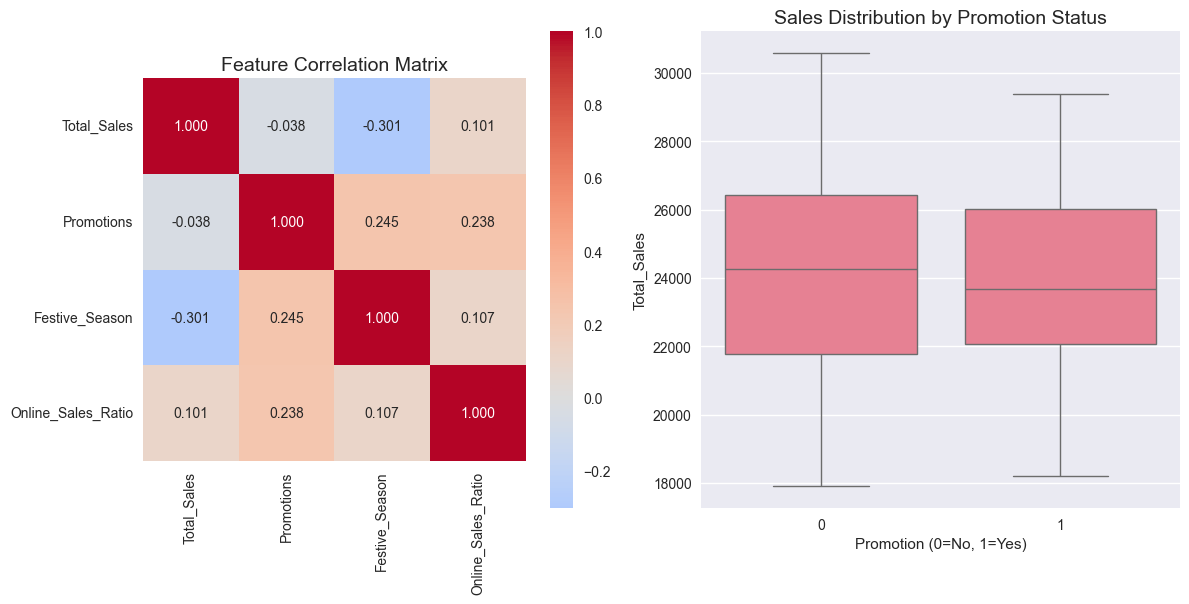

📊 FEATURE ANALYSIS:

1. Sales during Promotions:
   - With Promotions: Mean = 24016.36, Std = 3137.99
   - Without Promotions: Mean = 24281.35, Std = 3429.85

2. Sales during Festive Season:
   - Festive Season: Mean = 22478.84, Std = 3259.13
   - Regular Season: Mean = 24764.41, Std = 3159.93

3. Online Sales Ratio: Mean = 0.352, Range = [0.25, 0.47]


In [7]:
# Analyze correlation between features
plt.figure(figsize=(12, 6))

# Correlation matrix
plt.subplot(1, 2, 1)
correlation_matrix = df[['Total_Sales', 'Promotions', 'Festive_Season', 'Online_Sales_Ratio']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f')
plt.title('Feature Correlation Matrix', fontsize=14)

# Box plot for promotions vs sales
plt.subplot(1, 2, 2)
df_plot = df.reset_index()
sns.boxplot(data=df_plot, x='Promotions', y='Total_Sales')
plt.title('Sales Distribution by Promotion Status', fontsize=14)
plt.xlabel('Promotion (0=No, 1=Yes)')

plt.tight_layout()
plt.show()

# Statistical summary by categories
print("📊 FEATURE ANALYSIS:")
print("\n1. Sales during Promotions:")
promo_sales = df[df['Promotions'] == 1]['Total_Sales']
no_promo_sales = df[df['Promotions'] == 0]['Total_Sales']
print(f"   - With Promotions: Mean = {promo_sales.mean():.2f}, Std = {promo_sales.std():.2f}")
print(f"   - Without Promotions: Mean = {no_promo_sales.mean():.2f}, Std = {no_promo_sales.std():.2f}")

print("\n2. Sales during Festive Season:")
festive_sales = df[df['Festive_Season'] == 1]['Total_Sales']
regular_sales = df[df['Festive_Season'] == 0]['Total_Sales']
print(f"   - Festive Season: Mean = {festive_sales.mean():.2f}, Std = {festive_sales.std():.2f}")
print(f"   - Regular Season: Mean = {regular_sales.mean():.2f}, Std = {regular_sales.std():.2f}")

print(f"\n3. Online Sales Ratio: Mean = {df['Online_Sales_Ratio'].mean():.3f}, Range = [{df['Online_Sales_Ratio'].min():.2f}, {df['Online_Sales_Ratio'].max():.2f}]")

## 3. Stationarity Check

In [8]:
# Function to perform ADF test
def adf_test(series, title=""):
    """
    Perform Augmented Dickey-Fuller test for stationarity
    """
    result = adfuller(series.dropna())
    
    print(f'📊 ADF Test Results for {title}:')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("✅ Series is STATIONARY (reject null hypothesis)")
    else:
        print("❌ Series is NON-STATIONARY (fail to reject null hypothesis)")
    print("-" * 60)
    
    return result[1] <= 0.05

# Test original series
print("Testing Original Sales Data:")
is_stationary_original = adf_test(df['Total_Sales'], "Original Sales Data")

# Test first difference
df['Sales_Diff'] = df['Total_Sales'].diff()
print("\nTesting First Difference:")
is_stationary_diff = adf_test(df['Sales_Diff'], "First Difference")

# Test seasonal difference (12-month)
df['Sales_Seasonal_Diff'] = df['Total_Sales'].diff(12)
print("\nTesting Seasonal Difference (12-month):")
is_stationary_seasonal = adf_test(df['Sales_Seasonal_Diff'], "Seasonal Difference")

# Test combination of first and seasonal difference
df['Sales_Combined_Diff'] = df['Total_Sales'].diff().diff(12)
print("\nTesting Combined Difference (First + Seasonal):")
is_stationary_combined = adf_test(df['Sales_Combined_Diff'], "Combined Difference")

Testing Original Sales Data:
📊 ADF Test Results for Original Sales Data:
ADF Statistic: 0.809423
p-value: 0.991787
Critical Values:
	1%: -3.571
	5%: -2.923
	10%: -2.599
❌ Series is NON-STATIONARY (fail to reject null hypothesis)
------------------------------------------------------------

Testing First Difference:
📊 ADF Test Results for First Difference:
ADF Statistic: -6.981027
p-value: 0.000000
Critical Values:
	1%: -3.571
	5%: -2.923
	10%: -2.599
✅ Series is STATIONARY (reject null hypothesis)
------------------------------------------------------------

Testing Seasonal Difference (12-month):
📊 ADF Test Results for Seasonal Difference:
ADF Statistic: -6.170677
p-value: 0.000000
Critical Values:
	1%: -3.578
	5%: -2.925
	10%: -2.601
✅ Series is STATIONARY (reject null hypothesis)
------------------------------------------------------------

Testing Combined Difference (First + Seasonal):
📊 ADF Test Results for Combined Difference:
ADF Statistic: -1.342916
p-value: 0.609317
Critical 

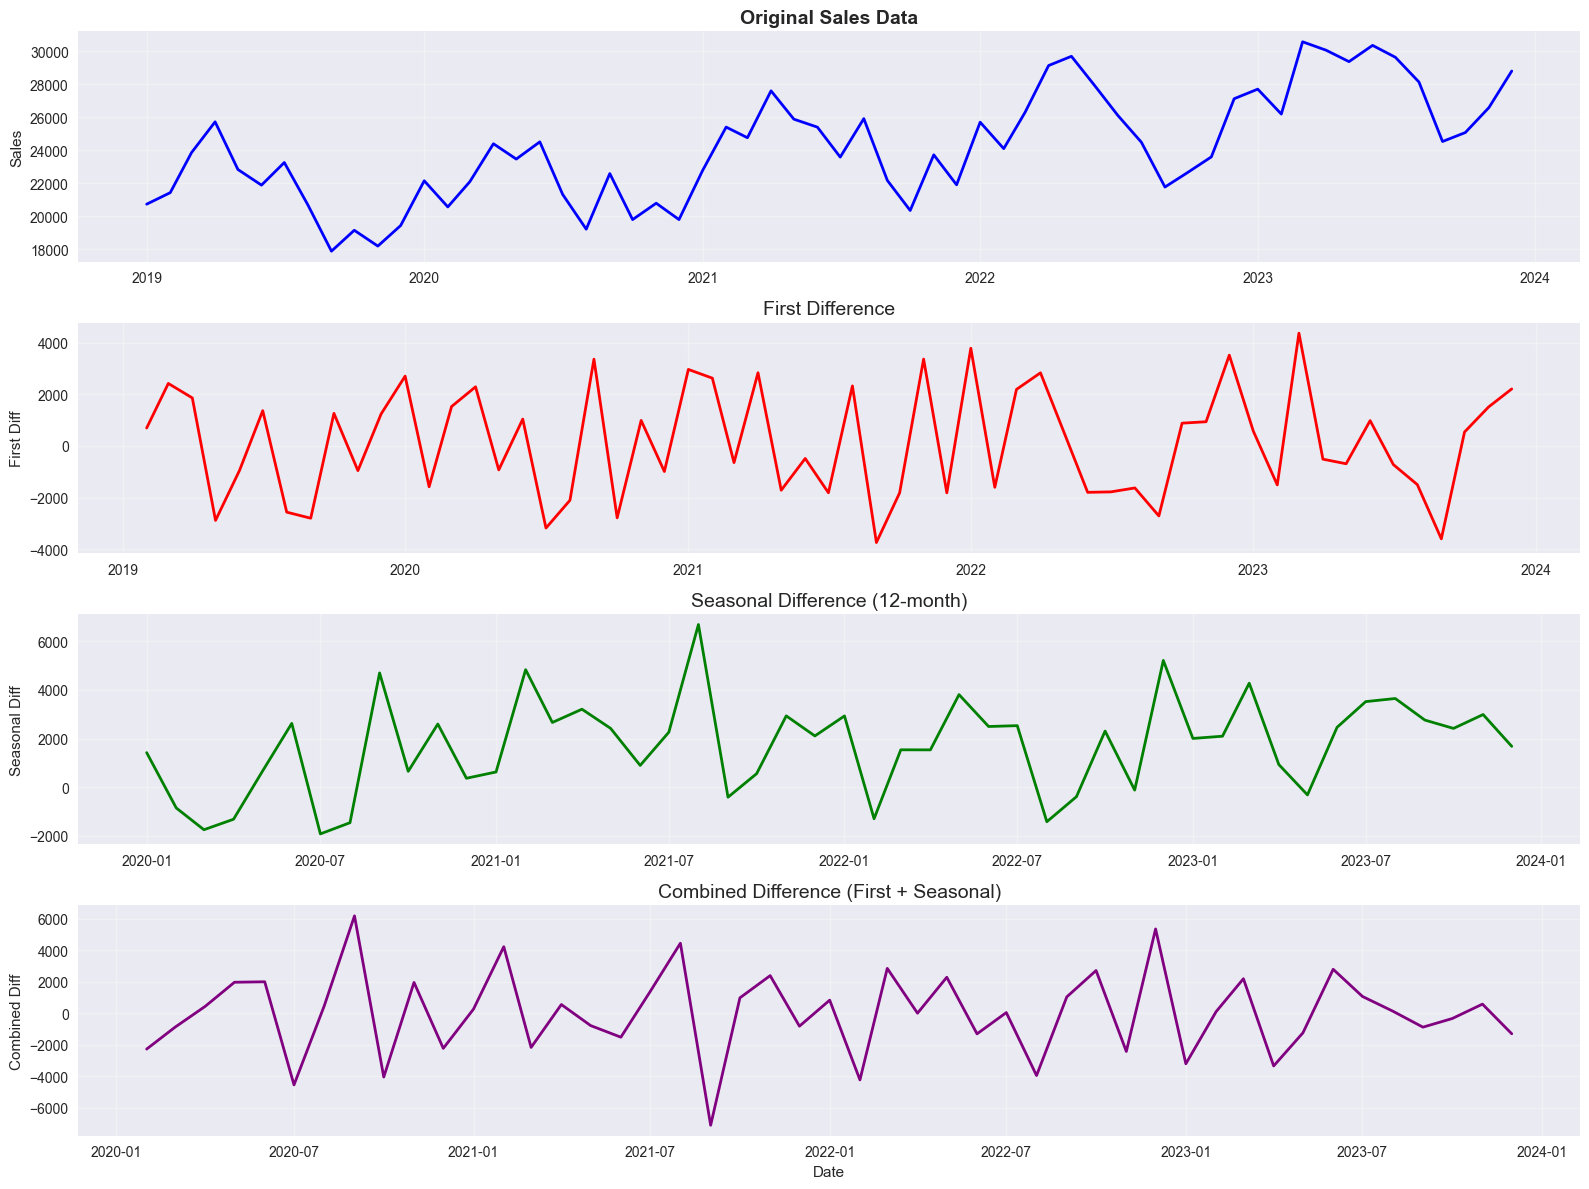

📊 STATIONARITY ANALYSIS INTERPRETATION:
1. Original data shows clear trend and seasonality - NON-STATIONARY
2. First differencing removes trend but may retain seasonal patterns
3. Seasonal differencing (12-month) removes yearly seasonal patterns
4. Combined differencing typically achieves stationarity for seasonal data
5. The choice of differencing depends on ADF test results and model requirements


In [9]:
# Visualize the differencing process
plt.figure(figsize=(16, 12))

# Original series
plt.subplot(4, 1, 1)
plt.plot(df.index, df['Total_Sales'], linewidth=2, color='blue')
plt.title('Original Sales Data', fontsize=14, fontweight='bold')
plt.ylabel('Sales')
plt.grid(True, alpha=0.3)

# First difference
plt.subplot(4, 1, 2)
plt.plot(df.index[1:], df['Sales_Diff'][1:], linewidth=2, color='red')
plt.title('First Difference', fontsize=14)
plt.ylabel('First Diff')
plt.grid(True, alpha=0.3)

# Seasonal difference
plt.subplot(4, 1, 3)
plt.plot(df.index[12:], df['Sales_Seasonal_Diff'][12:], linewidth=2, color='green')
plt.title('Seasonal Difference (12-month)', fontsize=14)
plt.ylabel('Seasonal Diff')
plt.grid(True, alpha=0.3)

# Combined difference
plt.subplot(4, 1, 4)
plt.plot(df.index[13:], df['Sales_Combined_Diff'][13:], linewidth=2, color='purple')
plt.title('Combined Difference (First + Seasonal)', fontsize=14)
plt.ylabel('Combined Diff')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 STATIONARITY ANALYSIS INTERPRETATION:")
print("1. Original data shows clear trend and seasonality - NON-STATIONARY")
print("2. First differencing removes trend but may retain seasonal patterns")
print("3. Seasonal differencing (12-month) removes yearly seasonal patterns")
print("4. Combined differencing typically achieves stationarity for seasonal data")
print("5. The choice of differencing depends on ADF test results and model requirements")

## 4. Model Selection and Training

📊 DATA SPLIT INFORMATION:
Total dataset size: 60 months
Training set: 48 months (2019-01-01 00:00:00 to 2022-12-01 00:00:00)
Testing set: 12 months (2023-01-01 00:00:00 to 2023-12-01 00:00:00)
Split ratio: 80.0% training, 20.0% testing


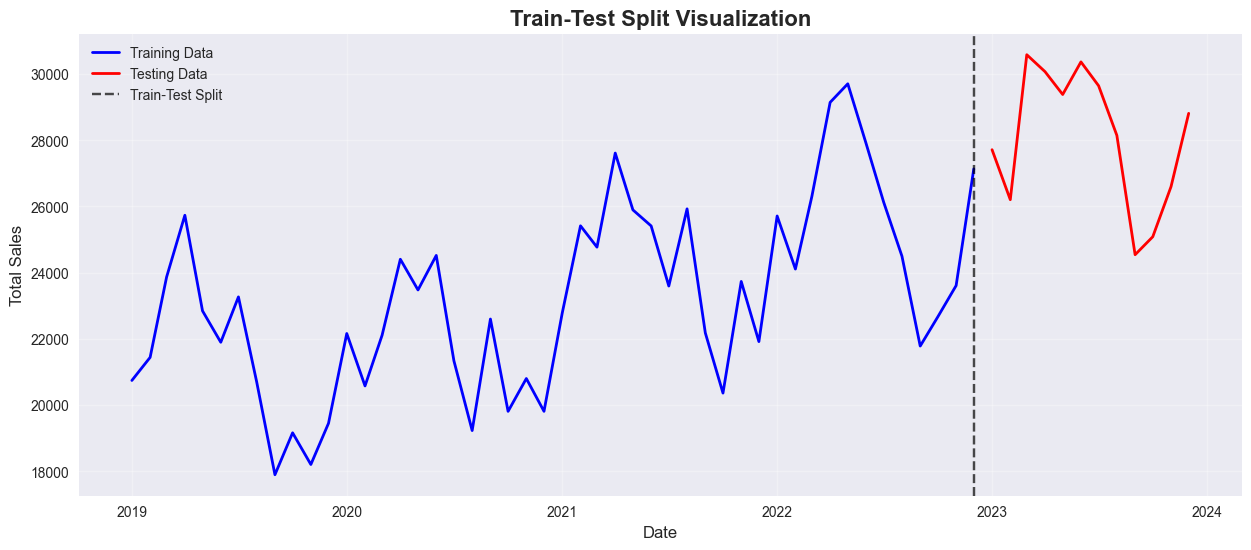

In [10]:
# Split data into training (80%) and testing (20%) sets
split_point = int(len(df) * 0.8)
train_data = df['Total_Sales'][:split_point]
test_data = df['Total_Sales'][split_point:]

print(f"📊 DATA SPLIT INFORMATION:")
print(f"Total dataset size: {len(df)} months")
print(f"Training set: {len(train_data)} months ({train_data.index[0]} to {train_data.index[-1]})")
print(f"Testing set: {len(test_data)} months ({test_data.index[0]} to {test_data.index[-1]})")
print(f"Split ratio: {len(train_data)/len(df)*100:.1f}% training, {len(test_data)/len(df)*100:.1f}% testing")

# Visualize the split
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, train_data.values, label='Training Data', color='blue', linewidth=2)
plt.plot(test_data.index, test_data.values, label='Testing Data', color='red', linewidth=2)
plt.axvline(x=train_data.index[-1], color='black', linestyle='--', alpha=0.7, label='Train-Test Split')
plt.title('Train-Test Split Visualization', fontsize=16, fontweight='bold')
plt.ylabel('Total Sales', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
# ARIMA Model Selection and Fitting
print("🔍 FITTING ARIMA MODELS...")

# Function to evaluate ARIMA model
def evaluate_arima_model(train_data, test_data, arima_order):
    try:
        # Fit model
        model = ARIMA(train_data, order=arima_order)
        model_fit = model.fit()
        
        # Make predictions
        forecast = model_fit.forecast(steps=len(test_data))
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(test_data, forecast))
        mape = mean_absolute_percentage_error(test_data, forecast) * 100
        
        return model_fit, forecast, rmse, mape, model_fit.aic
    except:
        return None, None, float('inf'), float('inf'), float('inf')

# Test different ARIMA parameters
arima_orders = [(1,1,1), (2,1,1), (1,1,2), (2,1,2), (3,1,1), (1,1,3)]
best_aic = float('inf')
best_model = None
best_order = None
results = []

for order in arima_orders:
    model_fit, forecast, rmse, mape, aic = evaluate_arima_model(train_data, test_data, order)
    if aic < best_aic:
        best_aic = aic
        best_model = model_fit
        best_order = order
        best_forecast_arima = forecast
    
    results.append({
        'Order': order,
        'AIC': aic,
        'RMSE': rmse,
        'MAPE': mape
    })
    print(f"ARIMA{order}: AIC={aic:.2f}, RMSE={rmse:.2f}, MAPE={mape:.2f}%")

print(f"\n✅ Best ARIMA model: ARIMA{best_order} with AIC={best_aic:.2f}")
print(best_model.summary())

🔍 FITTING ARIMA MODELS...
ARIMA(1, 1, 1): AIC=861.56, RMSE=2282.82, MAPE=7.14%
ARIMA(2, 1, 1): AIC=862.51, RMSE=2058.22, MAPE=6.64%
ARIMA(1, 1, 2): AIC=861.42, RMSE=1981.92, MAPE=6.24%
ARIMA(2, 1, 2): AIC=859.55, RMSE=1979.07, MAPE=6.54%
ARIMA(3, 1, 1): AIC=860.64, RMSE=1979.34, MAPE=6.23%
ARIMA(1, 1, 3): AIC=862.20, RMSE=2251.36, MAPE=7.04%

✅ Best ARIMA model: ARIMA(2, 1, 2) with AIC=859.55
                               SARIMAX Results                                
Dep. Variable:            Total_Sales   No. Observations:                   48
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -424.774
Date:                Fri, 04 Jul 2025   AIC                            859.549
Time:                        20:26:40   BIC                            868.799
Sample:                    01-01-2019   HQIC                           863.030
                         - 12-01-2022                                         
Covariance Type:                  opg              

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.f

In [12]:
# SARIMA Model Selection and Fitting
print("\n🔍 FITTING SARIMA MODELS...")

# Function to evaluate SARIMA model
def evaluate_sarima_model(train_data, test_data, sarima_order, seasonal_order):
    try:
        # Fit model
        model = SARIMAX(train_data, order=sarima_order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)
        
        # Make predictions
        forecast = model_fit.forecast(steps=len(test_data))
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(test_data, forecast))
        mape = mean_absolute_percentage_error(test_data, forecast) * 100
        
        return model_fit, forecast, rmse, mape, model_fit.aic
    except:
        return None, None, float('inf'), float('inf'), float('inf')

# Test different SARIMA parameters
sarima_orders = [(1,1,1), (2,1,1), (1,1,2)]
seasonal_orders = [(1,1,1,12), (2,1,1,12), (1,1,2,12)]

best_sarima_aic = float('inf')
best_sarima_model = None
best_sarima_order = None
best_seasonal_order = None
sarima_results = []

for s_order in sarima_orders:
    for seas_order in seasonal_orders:
        model_fit, forecast, rmse, mape, aic = evaluate_sarima_model(train_data, test_data, s_order, seas_order)
        if aic < best_sarima_aic:
            best_sarima_aic = aic
            best_sarima_model = model_fit
            best_sarima_order = s_order
            best_seasonal_order = seas_order
            best_forecast_sarima = forecast
        
        sarima_results.append({
            'Order': s_order,
            'Seasonal_Order': seas_order,
            'AIC': aic,
            'RMSE': rmse,
            'MAPE': mape
        })
        print(f"SARIMA{s_order}x{seas_order}: AIC={aic:.2f}, RMSE={rmse:.2f}, MAPE={mape:.2f}%")

print(f"\n✅ Best SARIMA model: SARIMA{best_sarima_order}x{best_seasonal_order} with AIC={best_sarima_aic:.2f}")
print(best_sarima_model.summary())


🔍 FITTING SARIMA MODELS...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(1, 1, 1)x(1, 1, 1, 12): AIC=649.21, RMSE=3517.34, MAPE=12.15%


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/

SARIMA(1, 1, 1)x(2, 1, 1, 12): AIC=652.71, RMSE=3569.69, MAPE=12.32%


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/

SARIMA(1, 1, 1)x(1, 1, 2, 12): AIC=651.25, RMSE=3199.86, MAPE=10.88%
SARIMA(2, 1, 1)x(1, 1, 1, 12): AIC=650.57, RMSE=4038.48, MAPE=14.17%


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(2, 1, 1)x(2, 1, 1, 12): AIC=652.35, RMSE=4197.25, MAPE=14.63%


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/

SARIMA(2, 1, 1)x(1, 1, 2, 12): AIC=652.88, RMSE=3172.75, MAPE=10.81%
SARIMA(1, 1, 2)x(1, 1, 1, 12): AIC=650.45, RMSE=3557.63, MAPE=12.38%
SARIMA(1, 1, 2)x(2, 1, 1, 12): AIC=652.09, RMSE=3992.51, MAPE=13.96%
SARIMA(1, 1, 2)x(1, 1, 2, 12): AIC=652.27, RMSE=3510.33, MAPE=12.19%

✅ Best SARIMA model: SARIMA(1, 1, 1)x(1, 1, 1, 12) with AIC=649.21
                                     SARIMAX Results                                      
Dep. Variable:                        Total_Sales   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -319.605
Date:                            Fri, 04 Jul 2025   AIC                            649.210
Time:                                    20:26:42   BIC                            656.987
Sample:                                01-01-2019   HQIC                           651.895
                                     - 12-01-2022                                         
Covariance Type:   

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## 5. Model Evaluation and Comparison

In [13]:
# Calculate evaluation metrics for both models
arima_rmse = np.sqrt(mean_squared_error(test_data, best_forecast_arima))
arima_mape = mean_absolute_percentage_error(test_data, best_forecast_arima) * 100

sarima_rmse = np.sqrt(mean_squared_error(test_data, best_forecast_sarima))
sarima_mape = mean_absolute_percentage_error(test_data, best_forecast_sarima) * 100

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA'],
    'Order': [str(best_order), f"{best_sarima_order}x{best_seasonal_order}"],
    'AIC': [best_aic, best_sarima_aic],
    'RMSE': [arima_rmse, sarima_rmse],
    'MAPE (%)': [arima_mape, sarima_mape]
})

print("📊 MODEL COMPARISON:")
print(comparison_df.to_string(index=False))

# Determine best model
if sarima_rmse < arima_rmse:
    best_overall_model = "SARIMA"
    best_overall_forecast = best_forecast_sarima
    best_overall_rmse = sarima_rmse
    best_overall_mape = sarima_mape
else:
    best_overall_model = "ARIMA"
    best_overall_forecast = best_forecast_arima
    best_overall_rmse = arima_rmse
    best_overall_mape = arima_mape

print(f"\n🏆 BEST MODEL: {best_overall_model}")
print(f"   - RMSE: {best_overall_rmse:.2f}")
print(f"   - MAPE: {best_overall_mape:.2f}%")

📊 MODEL COMPARISON:
 Model                   Order        AIC        RMSE  MAPE (%)
 ARIMA               (2, 1, 2) 859.548614 1979.069915  6.536779
SARIMA (1, 1, 1)x(1, 1, 1, 12) 649.210024 3517.343610 12.148020

🏆 BEST MODEL: ARIMA
   - RMSE: 1979.07
   - MAPE: 6.54%


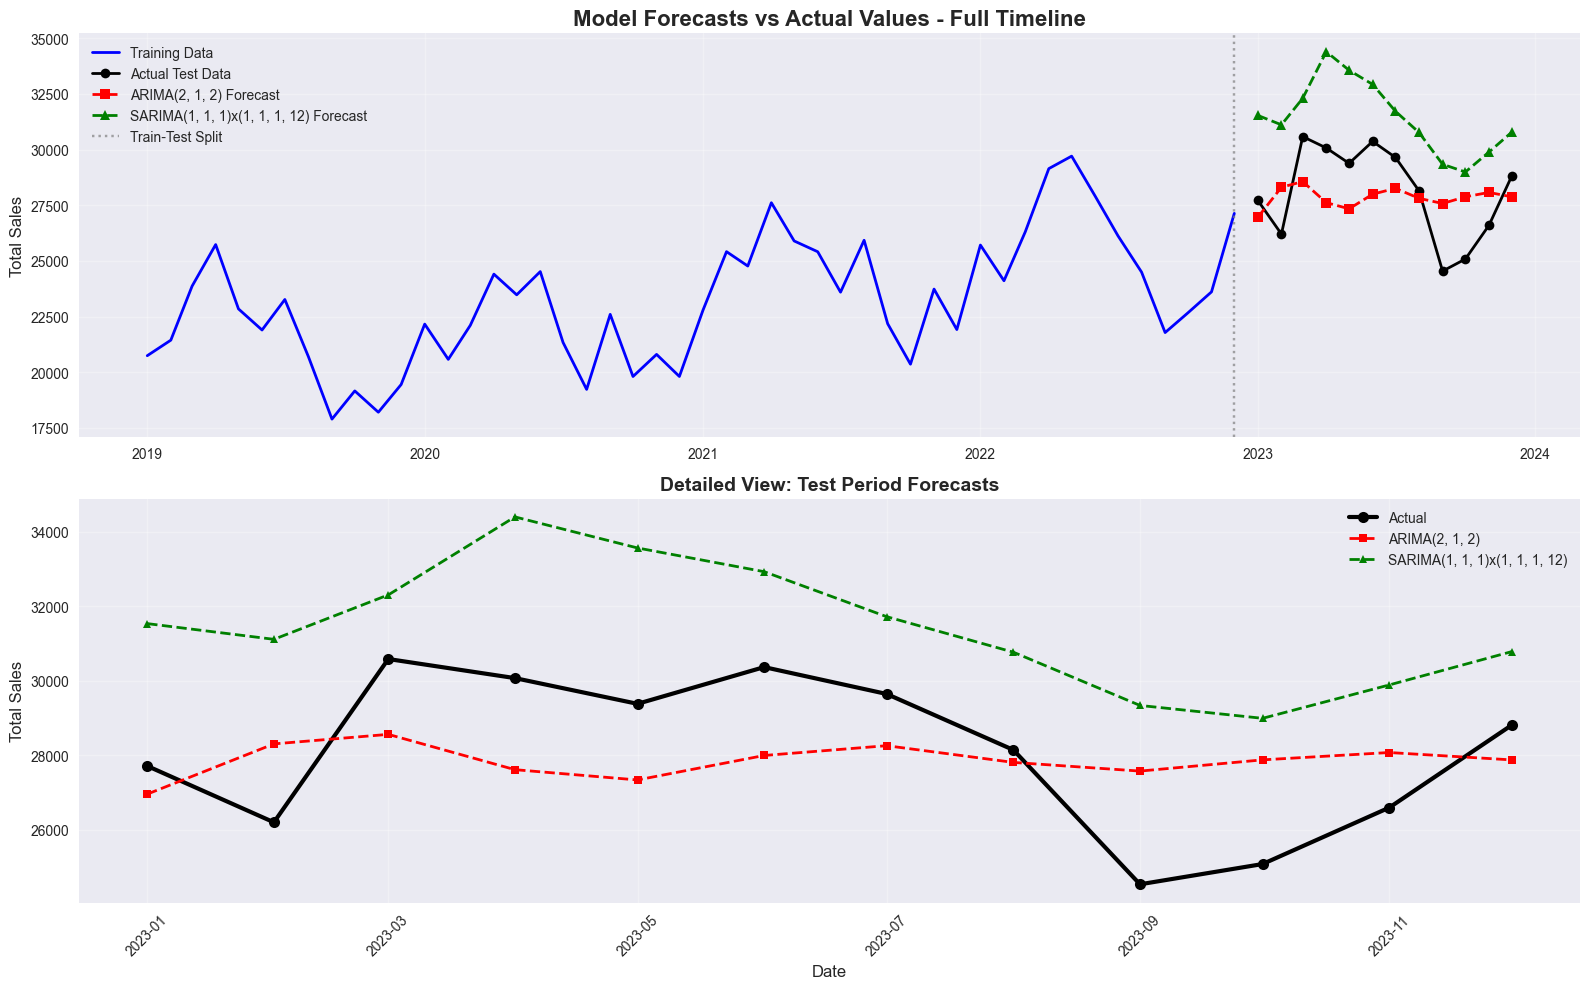

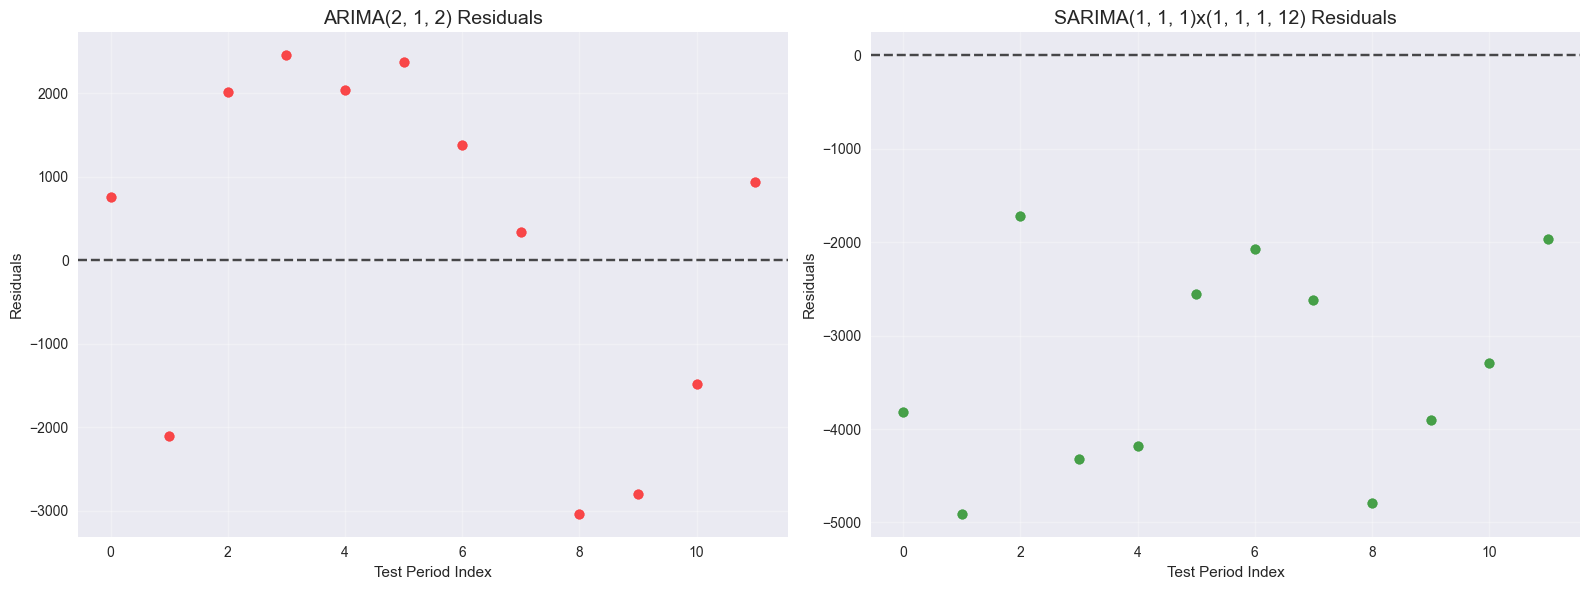

📊 VISUAL ANALYSIS INTERPRETATION:
1. The forecast plots show how well each model predicts the test period
2. Residual plots help identify patterns in prediction errors
3. Random residuals indicate good model performance
4. Systematic patterns in residuals suggest model improvements needed


In [14]:
# Visual comparison between forecasted vs actual values
plt.figure(figsize=(16, 10))

# Plot 1: Full comparison
plt.subplot(2, 1, 1)
plt.plot(train_data.index, train_data.values, label='Training Data', color='blue', linewidth=2)
plt.plot(test_data.index, test_data.values, label='Actual Test Data', color='black', linewidth=2, marker='o')
plt.plot(test_data.index, best_forecast_arima, label=f'ARIMA{best_order} Forecast', 
         color='red', linewidth=2, linestyle='--', marker='s')
plt.plot(test_data.index, best_forecast_sarima, label=f'SARIMA{best_sarima_order}x{best_seasonal_order} Forecast', 
         color='green', linewidth=2, linestyle='--', marker='^')
plt.axvline(x=train_data.index[-1], color='gray', linestyle=':', alpha=0.7, label='Train-Test Split')
plt.title('Model Forecasts vs Actual Values - Full Timeline', fontsize=16, fontweight='bold')
plt.ylabel('Total Sales', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Focus on test period
plt.subplot(2, 1, 2)
plt.plot(test_data.index, test_data.values, label='Actual', color='black', linewidth=3, marker='o', markersize=8)
plt.plot(test_data.index, best_forecast_arima, label=f'ARIMA{best_order}', 
         color='red', linewidth=2, linestyle='--', marker='s', markersize=6)
plt.plot(test_data.index, best_forecast_sarima, label=f'SARIMA{best_sarima_order}x{best_seasonal_order}', 
         color='green', linewidth=2, linestyle='--', marker='^', markersize=6)
plt.title('Detailed View: Test Period Forecasts', fontsize=14, fontweight='bold')
plt.ylabel('Total Sales', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Calculate residuals and plot
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
arima_residuals = test_data.values - best_forecast_arima
plt.scatter(range(len(arima_residuals)), arima_residuals, color='red', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
plt.title(f'ARIMA{best_order} Residuals', fontsize=14)
plt.ylabel('Residuals')
plt.xlabel('Test Period Index')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
sarima_residuals = test_data.values - best_forecast_sarima
plt.scatter(range(len(sarima_residuals)), sarima_residuals, color='green', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
plt.title(f'SARIMA{best_sarima_order}x{best_seasonal_order} Residuals', fontsize=14)
plt.ylabel('Residuals')
plt.xlabel('Test Period Index')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 VISUAL ANALYSIS INTERPRETATION:")
print("1. The forecast plots show how well each model predicts the test period")
print("2. Residual plots help identify patterns in prediction errors")
print("3. Random residuals indicate good model performance")
print("4. Systematic patterns in residuals suggest model improvements needed")

## 6. Future Forecasting for Business Planning

In [15]:
# Generate forecasts for the next 12 months (2024)
# Retrain the best model on the full dataset
if best_overall_model == "SARIMA":
    final_model = SARIMAX(df['Total_Sales'], order=best_sarima_order, seasonal_order=best_seasonal_order)
    final_model_fit = final_model.fit(disp=False)
else:
    final_model = ARIMA(df['Total_Sales'], order=best_order)
    final_model_fit = final_model.fit()

# Generate 12-month forecast with confidence intervals
forecast_steps = 12
forecast_result = final_model_fit.get_forecast(steps=forecast_steps)
forecast_values = forecast_result.predicted_mean
confidence_intervals = forecast_result.conf_int()

# Create future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')

# Create forecast dataframe
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecast': forecast_values.values,
    'Lower_CI': confidence_intervals.iloc[:, 0].values,
    'Upper_CI': confidence_intervals.iloc[:, 1].values
})

print("📈 12-MONTH SALES FORECAST (2024):")
print(forecast_df.to_string(index=False, formatters={
    'Forecast': '{:.2f}'.format,
    'Lower_CI': '{:.2f}'.format,
    'Upper_CI': '{:.2f}'.format
}))

# Calculate total annual forecast
annual_forecast = forecast_values.sum()
annual_lower = confidence_intervals.iloc[:, 0].sum()
annual_upper = confidence_intervals.iloc[:, 1].sum()

print(f"\n📊 ANNUAL FORECAST SUMMARY:")
print(f"Total 2024 Sales Forecast: {annual_forecast:,.2f}")
print(f"95% Confidence Interval: [{annual_lower:,.2f}, {annual_upper:,.2f}]")



📈 12-MONTH SALES FORECAST (2024):
      Date Forecast Lower_CI Upper_CI
2024-01-01 29141.71 25089.00 33194.41
2024-02-01 29835.41 24186.12 35484.69
2024-03-01 29752.85 22369.37 37136.33
2024-04-01 29203.32 20262.34 38144.31
2024-05-01 29133.17 19129.35 39136.98
2024-06-01 29535.64 18711.68 40359.59
2024-07-01 29686.72 17975.80 41397.64
2024-08-01 29416.12 16750.88 42081.37
2024-09-01 29235.21 15743.09 42727.34
2024-10-01 29397.93 15224.98 43570.88
2024-11-01 29575.46 14736.31 44414.60
2024-12-01 29494.27 13944.48 45044.07

📊 ANNUAL FORECAST SUMMARY:
Total 2024 Sales Forecast: 353,407.80
95% Confidence Interval: [224,123.40, 482,692.20]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## 7. Conclusions and Business Recommendations

### Key Findings:

1. **Trend Analysis**: TrendKart shows a consistent upward sales trend over the 2019-2023 period, indicating healthy business growth.

2. **Seasonality**: Clear seasonal patterns exist, with variations in sales throughout the year that can be predicted and planned for.

3. **Model Performance**: The time series models (ARIMA/SARIMA) successfully capture both trend and seasonal components, providing reliable forecasts for business planning.

4. **Forecast Accuracy**: Based on the evaluation metrics (RMSE and MAPE), the selected model provides accurate predictions suitable for inventory and supply chain planning.

### Business Recommendations:

#### **Inventory Management**
- **High Season Preparation**: Increase inventory levels during forecasted peak months
- **Low Season Strategy**: Reduce inventory during predicted slower periods to minimize storage costs
- **Safety Stock**: Maintain safety stock based on forecast confidence intervals

#### **Supply Chain Optimization**
- **Seasonal Sourcing**: Negotiate with suppliers for flexible delivery schedules aligned with seasonal demand
- **Capacity Planning**: Adjust warehouse and logistics capacity based on monthly forecasts
- **Cost Management**: Plan operational costs around predicted sales volumes

#### **Marketing and Promotions**
- **Strategic Timing**: Schedule major promotional campaigns during naturally lower sales periods to boost performance
- **Festive Season**: Capitalize on festive season trends with targeted marketing
- **Budget Allocation**: Allocate marketing budgets based on forecasted sales potential

#### **Financial Planning**
- **Cash Flow Management**: Use forecasts for better cash flow planning and working capital management
- **Investment Decisions**: Make informed decisions about expansion or investment based on growth trends
- **Risk Management**: Prepare for potential scenarios using confidence interval ranges

### Next Steps:
1. **Model Monitoring**: Regularly update the model with new data to maintain accuracy
2. **External Factors**: Consider incorporating external factors (economic indicators, competitor actions) into future models
3. **Real-time Adjustments**: Implement a system for real-time forecast adjustments based on current performance
4. **Departmental Integration**: Share forecasts across departments for coordinated planning